# Tabla de Contenidos

1. Descripción de proyecto
2. Inicialización
3. Cargar datos
4. Procesamientos de datos


    4.1 Valores nulos
    4.2 Valores duplicados 
    
    
5. Analisis exploratorio de los datos
6. Comparación del grupo de control y el grupo de prueba


    6.1 Prueba t-student
    6.2 Prueba Z
    
    
7. Conclusiones

## Descripción de proyectos

Hemos recibido una tarea analítica de una tienda en línea internacional. Nuestros predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron. Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

**Descripción técnica**  
- Nombre de la prueba: recommender_system_test
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_card) y compras (purchase). En cada etapa del embudo product_page → product_card → purchase, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

## Inicialización


En esta sección vamos a cargar las librerías para el estudio

In [87]:
import pandas as pd
import statsmodels.api as sm
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

## Cargar datos

In [88]:
# creamos el dataframe que contiene el calendario de eventos de marketing para 2020
ab_project_marketing_event_us=pd.read_csv('/datasets/ab_project_marketing_events_us.csv',sep=',',parse_dates=['start_dt','finish_dt'])

In [89]:
ab_project_marketing_event_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [90]:
# mostramos el calendario de eventos
ab_project_marketing_event_us.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


---
Estructura ab_project_marketing_events_us.csv:
- name: el nombre del evento de marketing
- regions: regiones donde se llevará a cabo la campaña publicitaria
- start_dt: fecha de inicio de la campaña
- finish_dt: fecha de finalización de la campaña

In [91]:
final_ab_new_users_upd_us=pd.read_csv('/datasets/final_ab_new_users_upd_us.csv',sep=',',parse_dates=['first_date'])

In [92]:
# mostramos información general de los usuarios registrados
final_ab_new_users_upd_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [93]:
# mostramos parte de los usuarios registrados
final_ab_new_users_upd_us.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


---
Estructura final_ab_new_users_upd_us.csv:
- user_id
- first_date: fecha de inscripción
- region
- device: dispositivo utilizado para la inscripción

In [94]:
final_ab_events_upd_us=pd.read_csv('/datasets/final_ab_events_upd_us.csv',sep=',',parse_dates=['event_dt'])

In [95]:
# mostramos información general de los eventos de los usuarios
final_ab_events_upd_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [96]:
# mostramos parte de los eventos de los usuarios
final_ab_events_upd_us.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


---
Estructura final_ab_events_upd_us.csv:
- user_id
- event_dt: fecha y hora del evento
- event_name: nombre del tipo de evento
- details: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

In [97]:
final_ab_participants_upd_us=pd.read_csv('/datasets/final_ab_participants_upd_us.csv',sep=',')

In [98]:
# mostramos información general de los participantes de la prueba
final_ab_participants_upd_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [99]:
# mostramos parte de los participantes de la prueba
final_ab_participants_upd_us.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


---
Estructura final_ab_participants_upd_us.csv:
- user_id
- ab_test: nombre de la prueba
- group: el grupo de prueba al que pertenecía el usuario

## Procesamiento de los datos

In [100]:
# buscamos los valores nulos en el dataframe de los eventos de los usuarios
final_ab_events_upd_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


### Valores nulos

In [101]:
# buscamos los eventos en los cuales hay valores nulos
final_ab_events_upd_us.groupby('event_name')['details'].count()

event_name
login               0
product_cart        0
product_page        0
purchase        60314
Name: details, dtype: int64

Notamos que los valores no nulos en `'details'` pertenecen al evento `'purchase'`, es decir; no tenemos valores nulos para las compras hechas. Por lo que al parecer no tenemos problemas en los datos.

### Valores duplicados  
Revisamos si tenemos registros duplicados en cada uno de los dataframes.

In [102]:
# revisamos valores duplicados en el calendario de eventos
ab_project_marketing_event_us.duplicated().sum()

0

In [103]:
# revisamos valores duplicados en el dataframe de usuarios registrados
final_ab_new_users_upd_us.duplicated().sum()

0

In [104]:
# revisamos valores duplicados en el dataframe de los eventos de los usuarios
final_ab_events_upd_us.duplicated().sum()

0

In [105]:
# revisamos valores duplicados en el dataframe de los participantes en la prueba
final_ab_participants_upd_us.duplicated().sum()

0

**No tenemos valores faltantes ni duplicados en los set de datos.** Antes de proceder al análisis exploratorio de los datos vamos a unir los dataframes para poder realizar los análisis posteriores.

In [106]:
final_ab_events_upd_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [107]:
# para unir el dataframe de eventos del usuario con el calendario de eventos necesitamos crear una columna con la fecha de 'event_dt'
final_ab_events_upd_us['event_date']=final_ab_events_upd_us['event_dt'].values.astype('datetime64[D]')
final_ab_events_upd_us.shape

(423761, 5)

In [108]:
# unimos los eventos de los usuarios con su fecha correspondiente en el calendario de eventos 
ab_users_events=final_ab_events_upd_us.merge(ab_project_marketing_event_us,left_on='event_date',right_on='start_dt',how='left')
ab_users_events.shape

(423761, 9)

Tenemos ahora asociado para cada evento el nombre del evento en el calendario. Unamos ahora el registro de usuarios con los datos de los participantes en la prueba.

In [109]:
# creamos un dataframe que contenga los usuarios que se registraron y participaron en la prueba
# unimos para cada registro de usuario su participacion en la prueba, unimos usando el 'user_id'
ab_users_groups=final_ab_new_users_upd_us.merge(final_ab_participants_upd_us,on='user_id',how='inner')
ab_users_groups

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...
14520,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test
14521,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
14522,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
14523,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


In [111]:
# Filtrar el DataFrame para mantener solo la región 'EU'
ab_users_groups = ab_users_groups[ab_users_groups['region'] == 'EU']

# Encuentra los usuarios que están en ambos tests
users_in_both_tests = recommender_system_users & interface_eu_users

# Filtra y modifica el DataFrame original para eliminar las filas con usuarios en ambos tests
ab_users_groups = ab_users_groups[~ab_users_groups['user_id'].isin(users_in_both_tests)]

# Ahora ab_users_groups contiene solo los usuarios que no están en ambos tests A/B
ab_users_groups

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...
14520,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test
14521,27007FC1A9B62FC5,2020-12-20,EU,iPhone,B,interface_eu_test
14522,75F25D4DADA37ABB,2020-12-20,EU,Android,B,interface_eu_test
14523,2C29721DDDA76B2A,2020-12-20,EU,iPhone,B,interface_eu_test


En este fragmento de código, se realizan varias operaciones en un DataFrame llamado ab_events_users_groups. El objetivo principal parece ser la manipulación de datos relacionados con pruebas A/B para analizar el comportamiento de los usuarios en diferentes tests.

El código se enfoca en trabajar con datos de usuarios de la región de EU que participaron en pruebas A/B. Primero, se filtran los datos por región. Luego, se identifican los usuarios que participaron en dos pruebas específicas y se eliminan del DataFrame aquellos usuarios que forman parte de ambos conjuntos de usuarios, con el objetivo de garantizar un análisis más preciso y evitar duplicaciones en los datos.

In [112]:
# agrupamos por la columna 'ab_test' para saber cuantos usuarios hay entre grupos
ab_users_groups.groupby('ab_test')['group'].value_counts()

ab_test                  group
interface_eu_test        A        5011
                         B        4952
recommender_system_test  A        1939
                         B         655
Name: group, dtype: int64

El número de eventos por usuario no está distribuido equitativamente entre las muestras en todas las pruebas.

Si observamos los datos proporcionados para las pruebas 'interface_eu_test' y 'recommender_system_test', podemos ver lo siguiente:

En la prueba 'interface_eu_test', el Grupo A tiene 5467 eventos por usuario, mientras que el Grupo B tiene 5383 eventos por usuario. En este caso, la diferencia no es significativa y la distribución es bastante equitativa entre los grupos.

En cambio, en la prueba 'recommender_system_test', hay una discrepancia notable en la distribución. El Grupo A tiene 2747 eventos por usuario, mientras que el Grupo B tiene solamente 928 eventos por usuario. Aquí, la distribución no es equitativa y la muestra del Grupo B tiene un número mucho menor de eventos por usuario en comparación con el Grupo A.

En resumen, la distribución de eventos por usuario varía entre las muestras según la prueba. Mientras que en 'interface_eu_test' la distribución es equitativa, en 'recommender_system_test' hay una disparidad considerable en el número de eventos por usuario entre los dos grupos.

In [113]:
# creamos un dataframe para los usuarios que participaron unicamente en la prueba 'recommender_system_test'
ab_users_groups_system=ab_users_groups.query('ab_test=="recommender_system_test"')
ab_users_groups_system.shape

(2594, 6)

In [114]:
# creamos un dataframe que contenga los eventos para los usuarios que participaron en la prueba
# unimos ahora los dataframe 'ab_users_events' y 'ab_users_groups_system' para poder asociar eventos y usuarios en los grupos de prueba
ab_events_users_groups=ab_users_events.merge(ab_users_groups_system,on='user_id',how='inner')
ab_events_users_groups.sample(5) # El objetivo es establecer una conexión entre los sucesos registrados y los usuarios agrupados en los contextos de prueba. Finalmente, presentamos una selección aleatoria de 10 entradas de este conjunto combinado para obtener una visión de la información.

,user_id,event_dt,event_name,details,event_date,name,regions,start_dt,finish_dt,first_date,region,device,group,ab_test
8421,A81312977901914F,2020-12-15 07:15:32,login,NaN,2020-12-15,NaN,NaN,NaT,NaT,2020-12-14,EU,PC,A,recommender_system_test
15650,FD11BEB17BD1E5F1,2020-12-28 05:59:00,login,NaN,2020-12-28,NaN,NaN,NaT,NaT,2020-12-09,EU,PC,B,recommender_system_test
9094,390D39CDD3AAC703,2020-12-23 01:11:28,product_page,NaN,2020-12-23,NaN,NaN,NaT,NaT,2020-12-16,EU,Android,A,recommender_system_test
5060,991220A6485D2BA1,2020-12-19 03:05:45,login,NaN,2020-12-19,NaN,NaN,NaT,NaT,2020-12-19,EU,PC,A,recommender_system_test
5174,AAED5CBA66F1C55B,2020-12-22 15:09:29,login,NaN,2020-12-22,NaN,NaN,NaT,NaT,2020-12-19,EU,PC,A,recommender_system_test


In [115]:
# mostramos el tamaño del dataframe creado
ab_events_users_groups.shape

(16959, 14)

In [116]:
# obtenemos la lista de clientes del grupo A
list_clientsA=ab_events_users_groups[ab_events_users_groups['group']=='A']['user_id'].unique()

In [117]:
# obtenemos la lista de clientes del grupo
list_clientsB=ab_events_users_groups[ab_events_users_groups['group']=='B']['user_id'].unique()

In [118]:
"creamos dos conjuntos con los 'user_id' de cada grupo y buscamos su intersección para ver los usuarios que aparecen en ambos conjunto"

set1 = set(list_clientsA)
set2 = set(list_clientsB)
set3 = set1 & set2

# usuarios en ambos grupos
list_clientsAB = list(set3)
print(f'Hay {len(list_clientsAB)} usuarios que aparecen en ambos grupos.')

Hay 0 usuarios que aparecen en ambos grupos.


## Análisis exploratorio de los datos

In [119]:
# veamos la distribución de los distintos tipos de eventos dentro de los grupos
event_proportion=ab_events_users_groups.groupby('group')['event_name'].value_counts(normalize=True)
event_proportion.name='proportion'
event_proportion=event_proportion.reset_index()
event_proportion

,group,event_name,proportion
0,A,login,0.443204
1,A,product_page,0.287072
2,A,product_cart,0.135918
3,A,purchase,0.133806
4,B,login,0.481221
5,B,product_page,0.255607
6,B,product_cart,0.132126
7,B,purchase,0.131046


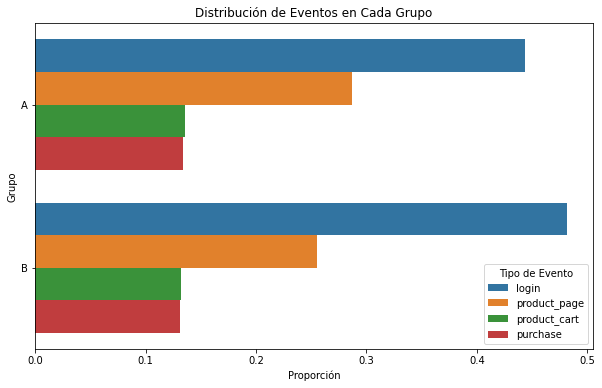

In [120]:
# Crear un gráfico de barras horizontal para la distribución de eventos en cada grupo
plt.figure(figsize=(10, 6))
sns.barplot(x='proportion', y='group', hue='event_name', data=event_proportion)
plt.xlabel('Proporción')
plt.ylabel('Grupo')
plt.title('Distribución de Eventos en Cada Grupo')
plt.legend(title='Tipo de Evento')
plt.show()

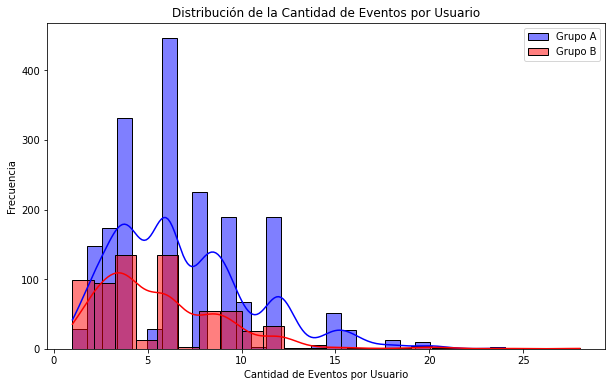

In [121]:
# Crear un gráfico de distribución para la cantidad de eventos por usuario
plt.figure(figsize=(10, 6))

# Obtener la cantidad de eventos por usuario para los grupos A y B
num_eventsA = ab_events_users_groups.query('group == "A"').groupby('user_id')['event_name'].count()
num_eventsB = ab_events_users_groups.query('group == "B"').groupby('user_id')['event_name'].count()

# Graficar la distribución de la cantidad de eventos por usuario para el grupo A
sns.histplot(num_eventsA, color='blue', label='Grupo A', kde=True)

# Graficar la distribución de la cantidad de eventos por usuario para el grupo B
sns.histplot(num_eventsB, color='red', label='Grupo B', kde=True)

plt.title('Distribución de la Cantidad de Eventos por Usuario')
plt.xlabel('Cantidad de Eventos por Usuario')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

En el gráfico anterior podemos notar que la cantidad de eventos por usuario tiene una distribución muy similar entre los dos grupos bajo estudio. En cambio a la frecuencia, el grupo A cuenta con mayor ocurrencia a estos eventos.

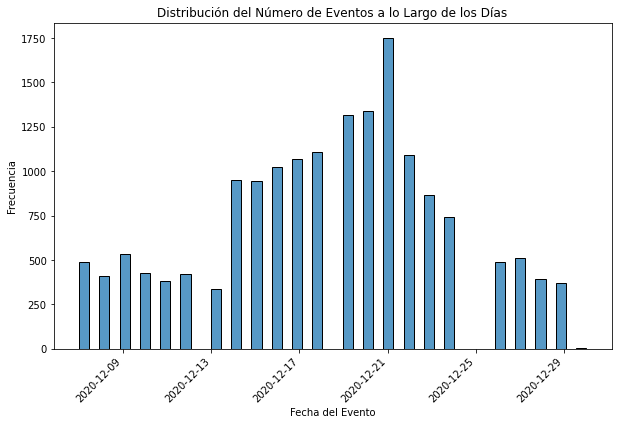

In [122]:
# Crear un gráfico de distribución de la cantidad de eventos entre los días
plt.figure(figsize=(10, 6))
sns.histplot(data=ab_events_users_groups, x='event_date', bins=50)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución del Número de Eventos a lo Largo de los Días')
plt.xlabel('Fecha del Evento')
plt.ylabel('Frecuencia')
plt.show()

Hemos observado un notable aumento en la cantidad de eventos a partir del 14 de diciembre de 2020, con un pico máximo el 21 de diciembre y luego una disminución gradual. En los últimos días del año 2020, la actividad registrada es bastante limitada.

Es importante resaltar que el mes de diciembre es conocido por ser una época en la que muchas personas realizan compras y dan regalos, especialmente en fechas como el 24, 25 y 31 de diciembre. Esta tendencia de compras podría impactar significativamente en la actividad de navegación y compras en tiendas, tanto en línea como físicas. En consecuencia, cualquier prueba que implique aumentar las compras o la navegación en un sitio web podría verse influida por este aumento estacional en la actividad de compra, en lugar de reflejar los cambios relacionados con la implementación de un sistema de recomendaciones mejorado.

Considerando este contexto, sería más prudente considerar la realización de la prueba del nuevo sistema de recomendaciones en un momento distinto, fuera de la temporada navideña. De esta manera, se podría obtener una perspectiva más precisa de cómo afecta el nuevo sistema en condiciones más estables, sin la interferencia de los patrones de compras típicos de esta época del año. Sin embargo, es cierto que en la actual temporada, tenemos la oportunidad de recopilar una gran cantidad de información valiosa para futuros estudios y análisis.

## Comparación del grupo de control y el grupo de prueba 

Probaremos si existe diferencia entre los grupos. Vamos a calcular la tasa de conversión de los usuarios en cada uno de los eventos dentro de cada grupo.

In [123]:
def perform_ttest(data, group_1, group_2, alpha, events):
    result_df = pd.DataFrame(columns=['event_name', 'statistics_t', 'p_value', 'alpha', 'p1', 'n_group_1',
                                      'p2', 'n_group_2', 'decision_H0', 'compared_groups'])

    for event in events:
        conversions = data[['user_id', 'group']].drop_duplicates()
        converted = pd.DataFrame(data={'user_id': data[data['event_name'] == event]['user_id'].unique(),
                                       'converted': 1})
        conversions = conversions.merge(converted, on='user_id', how='left')
        conversions['converted'] = conversions['converted'].fillna(0)

        sample_group_1 = conversions[conversions['group'] == group_1]['converted']
        n1 = len(sample_group_1)
        p1 = sample_group_1.mean()

        sample_group_2 = conversions[conversions['group'] == group_2]['converted']
        n2 = len(sample_group_2)
        p2 = sample_group_2.mean()

        statistics, p_value = st.ttest_ind(sample_group_1, sample_group_2)

        if p_value < alpha:
            decision = 'Reject H0'
        else:
            decision = 'Fail to reject H0'

        result_df.loc[len(result_df)] = [event, statistics, p_value, alpha, p1, n1, p2, n2,
                                         decision, f'{group_1} vs {group_2}']

    return result_df


In [124]:
# obtenemos la lista de los eventos a aplicar la prueba
eventos=['product_page','product_cart','purchase']

**Vamos a evaluar la siguiente hipótesis para cada tipo de evento:**

Hipótesis nula: No hay diferencia en la cantidad de usuarios convertidos entre los grupos que estamos comparando.

Hipótesis alternativa: Existe una diferencia en la cantidad de usuarios convertidos entre los grupos que estamos comparando.

Dado que estaremos analizando la media de dos conjuntos de datos, vamos a aplicar la prueba estadística 't de Student' (ttest_ind). Esta prueba se llevará a cabo con un nivel de significancia alpha establecido en 0.05. Asimismo, consideraremos que las varianzas de los grupos son comparables en magnitud.

In [125]:
# aplicamos la funcion para realizar las pruebas t-test
resultados_ttest = perform_ttest(data=ab_events_users_groups, group_1='A', group_2='B', alpha=0.05, events=eventos)
resultados_ttest

,event_name,statistics_t,p_value,alpha,p1,n_group_1,p2,n_group_2,decision_H0,compared_groups
0,product_page,4.231556,0.000024,0.05,0.652398,1939,0.560305,655,Reject H0,A vs B
1,product_cart,1.105218,0.269168,0.05,0.303765,1939,0.280916,655,Fail to reject H0,A vs B
2,purchase,1.173951,0.240523,0.05,0.316142,1939,0.291603,655,Fail to reject H0,A vs B


Hemos observado que solamente el evento denominado 'product_cart' no muestra significancia estadística. Esto implica que no tenemos suficiente evidencia para rechazar la hipótesis nula, que establece que la cantidad de usuarios convertidos es similar entre los grupos comparados. Nuestro nivel de confianza es del 95%, según el valor alfa que utilizamos. En resumen, el evento 'product_cart' no parece tener un impacto diferenciado en la conversión entre los grupos bajo estudio.

### Prueba Z para dos proporciones

In [126]:
def perform_ztest(data, group_1, group_2, alpha):
    result_df = pd.DataFrame(columns=['event_name', 'statistics_z', 'p_value', 'alpha', 'p1', 'n_group_1',
                                      'p2', 'n_group_2', 'decision_H0', 'compared_groups'])

    eventos = data['event_name'].unique()

    for event in eventos:
        conversions = data[['user_id', 'group']].drop_duplicates()
        converted = pd.DataFrame(data={'user_id': data[data['event_name'] == event]['user_id'].unique(),
                                       'converted': 1})
        conversions = conversions.merge(converted, on='user_id', how='left')
        conversions['converted'] = conversions['converted'].fillna(0)

        sample_group_1 = conversions[conversions['group'] == group_1]['converted']
        n1 = len(sample_group_1)
        p1 = sample_group_1.mean()

        sample_group_2 = conversions[conversions['group'] == group_2]['converted']
        n2 = len(sample_group_2)
        p2 = sample_group_2.mean()

        statistics, p_value = sm.stats.proportions_ztest([n1 * p1, n2 * p2], [n1, n2])

        if p_value < alpha:
            decision = 'Reject H0'
        else:
            decision = 'Fail to reject H0'

        result_df.loc[len(result_df)] = [event, statistics, p_value, alpha, p1, n1, p2, n2,
                                         decision, f'{group_1} vs {group_2}']

    return result_df

**Vamos a poner a prueba la siguiente hipótesis para cada tipo de evento:**

Hipótesis nula: La proporción de usuarios convertidos es idéntica entre los grupos bajo comparación.

Hipótesis alternativa: La proporción de usuarios convertidos no es idéntica entre los grupos bajo comparación.

Dado que estaremos evaluando la diferencia en proporciones entre dos conjuntos de datos, utilizaremos la prueba estadística 'Z para dos proporciones' (stats.proportions_ztest). Esta prueba se llevará a cabo con un nivel de significancia alpha establecido en 0.05.

In [127]:
# Aplicamos la función para realizar las pruebas z-test
resultado_ztest = perform_ztest(data=ab_events_users_groups, group_1='A', group_2='B', alpha=0.05)
resultado_ztest

,event_name,statistics_z,p_value,alpha,p1,n_group_1,p2,n_group_2,decision_H0,compared_groups
0,purchase,1.174092,0.240358,0.05,0.316142,1939,0.291603,655,Fail to reject H0,A vs B
1,product_cart,1.105384,0.268993,0.05,0.303765,1939,0.280916,655,Fail to reject H0,A vs B
2,login,1.720886,0.085272,0.05,1.000000,1939,0.998473,655,Fail to reject H0,A vs B
3,product_page,4.218641,0.000025,0.05,0.652398,1939,0.560305,655,Reject H0,A vs B



Observamos que solamente el evento 'product_cart' carece de significancia estadística, lo que implica que no tenemos suficiente evidencia para rechazar la hipótesis nula de que la proporción de usuarios convertidos es idéntica entre los grupos comparados. Esta observación concuerda con los resultados obtenidos de la prueba 't-test', y ambos análisis se han realizado utilizando un valor alfa del 5%.

## Conclusión

Los eventos 'product_page' y 'purchase' han demostrado diferencias estadísticas significativas en su desempeño. Los valores de p1 en estos eventos sugieren que las proporciones son mayores en el grupo A en comparación con el grupo B. Una posible explicación podría residir en el tamaño de la muestra utilizado en el estudio. Inicialmente, se planificó contar con la participación de seis mil usuarios, sin embargo, en los datos reales solo tenemos registros de 3,1 usuarios..

Es interesante notar que el grupo A cuenta con una cantidad considerablemente mayor de usuarios (1939) en comparación con el grupo B (655), lo que resulta en una discrepancia notable entre los tamaños de muestra. Esta disparidad puede influir en los resultados, ya que las diferencias podrían atribuirse tanto a las características intrínsecas de los grupos como a las fluctuaciones naturales en datos de menor tamaño.

En resumen, las diferencias estadísticas entre los eventos 'product_page' y 'purchase', junto con las proporciones divergentes observadas, pueden atribuirse al tamaño desigual de las muestras y a la posible variabilidad en el comportamiento de los usuarios en cada grupo.